 ## BAF Veri Setinden GAN ile Yapay Veri Üretimi

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler

C:\Users\Beyza\anaconda3\anacondaa3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Beyza\anaconda3\anacondaa3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('base.csv')  
data = pd.read_csv('base.csv') 

categorical_columns = ['income', 'customer_age', 'payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'device_distinct_emails_8w', 'device_fraud_count', 'month']

encoder = OneHotEncoder(sparse=False, drop='first')
encoded_df = pd.DataFrame(encoder.fit_transform(df[categorical_columns]))

encoded_df.columns = encoder.get_feature_names_out(categorical_columns)

df = df.drop(columns=categorical_columns)

df = pd.concat([df, encoded_df], axis=1)

fraud_bool = df['fraud_bool']

binary_columns = ["email_is_free","phone_home_valid","phone_mobile_valid","has_other_cards","foreign_request","keep_alive_session"]  # Binary sütunların isimleri
columns_to_scale = df.columns.difference(['fraud_bool'] + binary_columns)
scaler = MinMaxScaler()
scaled_df = df.copy()
scaled_df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

scaled_df['fraud_bool'] = fraud_bool
scaled_df[binary_columns] = df[binary_columns] 

In [3]:
latent_dim = 1024
num_epochs = 100  
batch_size = 64

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(input_dim=latent_dim, output_dim=scaled_df.shape[1]).to(device)
discriminator = Discriminator(input_dim=scaled_df.shape[1]).to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=0.0003, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999))
criterion = nn.BCELoss()

data_tensor = torch.tensor(scaled_df.values, dtype=torch.float32).to(device)
train_loader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)


def train_model():
    start_time = time.time()
    for epoch in range(num_epochs):
        for real_data in train_loader:
            real_data = real_data[0]

            batch_size = real_data.size(0)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            optimizer_d.zero_grad()
            outputs = discriminator(real_data)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(z)
            outputs = discriminator(fake_data.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            optimizer_d.step()

            optimizer_g.zero_grad()
            outputs = discriminator(fake_data)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()

        print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss_real.item() + d_loss_fake.item()} | G Loss: {g_loss.item()}')
    
    end_time = time.time()
    return end_time - start_time

if device.type == 'cuda':
    gpu_time = train_model()
    print(f"GPU eğitim süresi: {gpu_time:.2f} saniye")
else:
    cpu_time = train_model()
    print(f"CPU eğitim süresi: {cpu_time:.2f} saniye")


Epoch [1/100] | D Loss: 1.4088842868804932 | G Loss: 0.6576639413833618
Epoch [2/100] | D Loss: 0.2510593384504318 | G Loss: 3.103882312774658
Epoch [3/100] | D Loss: 0.33347989432513714 | G Loss: 3.4771387577056885
Epoch [4/100] | D Loss: 0.2580423057079315 | G Loss: 3.9401233196258545
Epoch [5/100] | D Loss: 0.15777438506484032 | G Loss: 5.110479354858398
Epoch [6/100] | D Loss: 0.16200136207044125 | G Loss: 7.235379219055176
Epoch [7/100] | D Loss: 0.11249049752950668 | G Loss: 8.842010498046875
Epoch [8/100] | D Loss: 0.11893841437995434 | G Loss: 7.874172210693359
Epoch [9/100] | D Loss: 0.05386572191491723 | G Loss: 10.239445686340332
Epoch [10/100] | D Loss: 0.07627055840566754 | G Loss: 10.505271911621094
Epoch [11/100] | D Loss: 0.03464857209473848 | G Loss: 9.868450164794922
Epoch [12/100] | D Loss: 0.11419719265541062 | G Loss: 10.488202095031738
Epoch [13/100] | D Loss: 0.2341160483774729 | G Loss: 10.518189430236816
Epoch [14/100] | D Loss: 0.02049172791885212 | G Loss: 1

In [4]:
num_samples = 1000000
noise = torch.randn(num_samples, latent_dim)

generated_data = generator(noise).detach().numpy()

generated_df = pd.DataFrame(generated_data, columns=scaled_df.columns)
generated_df[columns_to_scale] = scaler.inverse_transform(generated_df[columns_to_scale])
generated_df[binary_columns] = (generated_df[binary_columns] > 0.5).astype(int)

categorical_output = pd.DataFrame(encoder.inverse_transform(generated_df[encoded_df.columns]))
categorical_output.columns = categorical_columns

generated_df = generated_df.drop(columns=encoded_df.columns)
generated_df = pd.concat([generated_df, categorical_output], axis=1)

In [5]:
generated_df.head()

,fraud_bool,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,...,income,customer_age,payment_type,employment_status,housing_status,source,device_os,device_distinct_emails_8w,device_fraud_count,month
0,-1.0,0.999999,383.0,-430.0,-78.456902,112.956924,-6698.0,16715.566406,9506.897461,6994.764160,...,0.2,20,AA,CC,BB,TELEAPP,macintosh,1,0,1
1,-1.0,-0.999996,383.0,428.0,78.456902,-144.018036,6700.0,16715.566406,9506.897461,-1343.267456,...,0.2,20,AB,CC,BA,TELEAPP,macintosh,1,0,1
2,-1.0,-0.999996,-385.0,428.0,-78.456902,-144.018036,-6698.0,16715.566406,9506.897461,6994.764160,...,0.2,20,AB,CC,BB,TELEAPP,macintosh,1,0,1
3,1.0,0.999999,-385.0,428.0,78.456902,-144.018036,6700.0,16715.566406,9506.897461,-1343.267456,...,0.2,20,AB,CC,BA,TELEAPP,macintosh,0,0,1
4,1.0,0.999999,-385.0,428.0,-78.456902,-144.018036,-6698.0,16715.566406,9506.897461,-1343.267456,...,0.7,10,AA,CA,BC,TELEAPP,linux,0,0,1


In [6]:
generated_df["fraud_bool"] = generated_df["fraud_bool"].astype(int)

In [7]:
df_sorted = generated_df.sort_values(by='fraud_bool', ascending=False).reset_index()

df_sorted.loc[:9999, 'fraud_bool'] = 1  
df_sorted.loc[10000:, 'fraud_bool'] = 0  

generated_df['fraud_bool'] = df_sorted.sort_values(by='index').reset_index(drop=True)['fraud_bool']

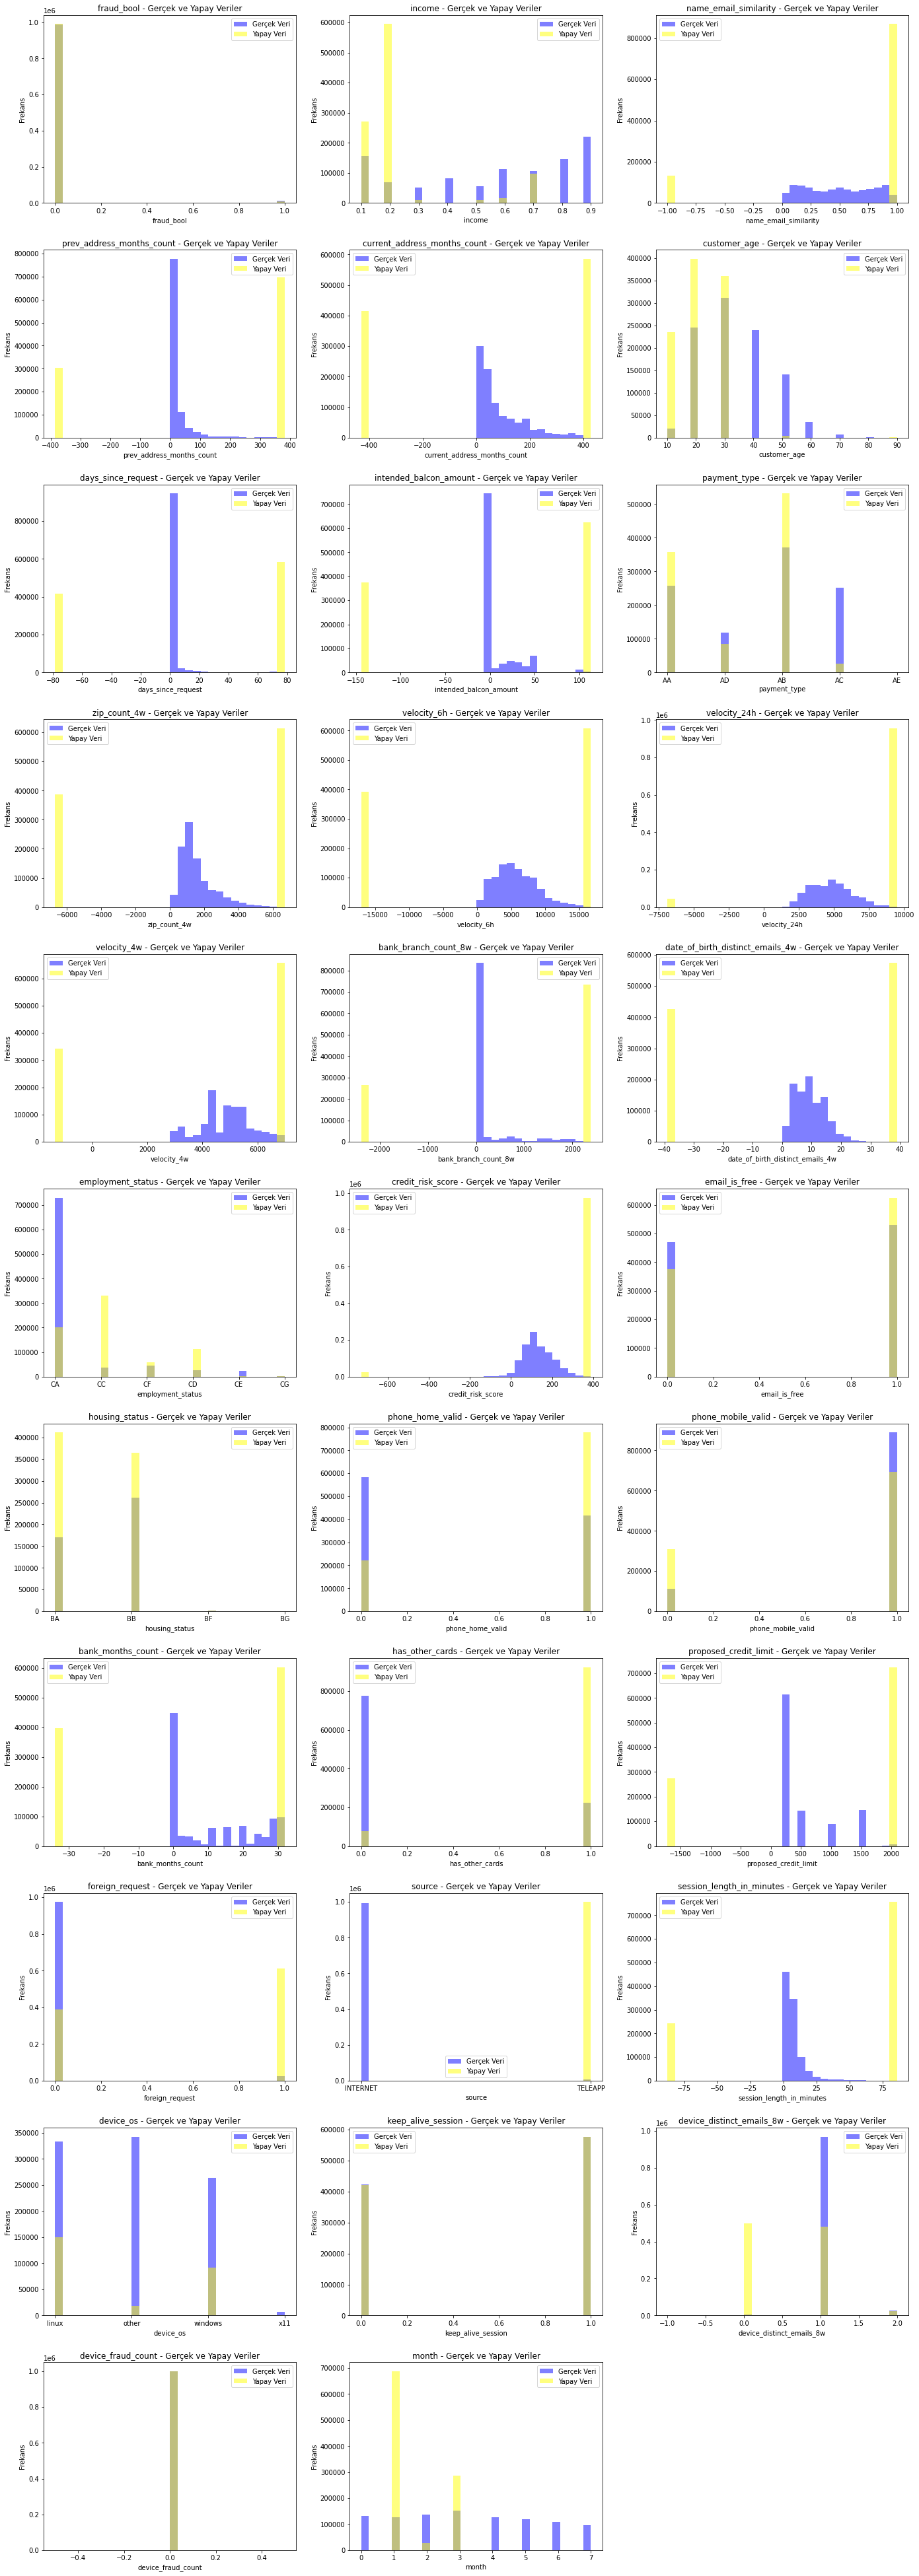

In [8]:
df = data

features = df.columns

num_features = len(features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
fig.tight_layout(pad=5.0)  

for i, feature in enumerate(features):
    row = i // num_columns
    col = i % num_columns
    
    ax = axes[row, col]
    
    min_val = min(df[feature].min(), generated_df[feature].min())
    max_val = max(df[feature].max(), generated_df[feature].max())
    
    ax.hist(df[feature], bins=30, alpha=0.5, label='Gerçek Veri', color='blue', range=(min_val, max_val))
    ax.hist(generated_df[feature], bins=30, alpha=0.5, label='Yapay Veri', color='yellow', range=(min_val, max_val))
    
    ax.set_title(f'{feature} - Gerçek ve Yapay Veriler')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frekans')
    ax.legend()

for j in range(len(features), num_rows * num_columns):
    fig.delaxes(axes[j // num_columns, j % num_columns])

plt.show()